# TVC Site Selector

Statistical approach to site selection based on previous TVC obs.
Takes input of processed rasters at a 25 m resolution that 
represent snow depth, veg height, slope, and elevation. We do a bit
of pre-processing to remove areas with tall veg and steep slopes. 
Sites are then selected randomly based on an inversion of the cumulative
density function. A seed needs to be set if you want to have the same set
of random sites show up on sequential runs.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
print(gpd.pd.__version__)

0.23.4


In [2]:
siksik_data = gpd.read_file('./data/shapefiles/geodata.shp').dropna()
siksik_shp = gpd.read_file('./data/shapefiles/siksik.shp')
siksik_geoms = siksik_shp.iloc[0].geometry

veg_max = 0.5 # Max veg height in m we're willing to deal with
slope_max = 15 # Max slope in deg we're willing to deal with

# subset our data based on multiple criteria
siksik_sub = siksik_data.loc[
    (siksik_data.geometry.within(siksik_geoms)) & 
    (siksik_data.vegheight_ <= veg_max) & 
    (siksik_data.slope_valu <= slope_max)
]

Establish bin size for the initial density function

In [3]:
snow_max = np.ceil(siksik_sub.snow_depth.max()) 
snow_min = 0.05 # helps avoid water-bodies being selected as sites *brrr*
snow_step = 0.01 #Bin width of 1 cm
bsnow = np.arange(snow_min,snow_max,snow_step) #These are the histogram bins

Here we calculate a probability density function (PDF), invert its cumulative density (CDF).
The bins are bound by the observations so we don't extrapolate.

In [4]:
hist, bin_edges = np.histogram(siksik_sub.snow_depth, bins=bsnow, density=True)
cum_values = np.zeros(bin_edges.shape)
cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
inv_cdf = interpolate.interp1d(cum_values, bin_edges)

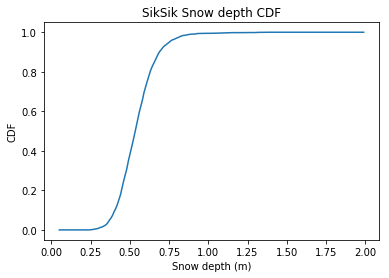

In [5]:
fig, ax = plt.subplots()
ax.plot(bin_edges, cum_values)
ax.set_xlabel("Snow depth (m)")
ax.set_ylabel("CDF")
ax.set_title('SikSik Snow depth CDF');

Example of how to pull random samples from the distribution

1. Select number of samples (`n_samples`)
2. Generate `n_samples` random numbers between 0-1
3. Use the inverted cdf to pull samples from the known distribution
4. Find nearest match in the obs. Need to do this because we interpolate the cdf.

If you pull enough samples, you'll recreate the observed distribution.

In [6]:
# set the seed to maintain repeatability
seed = 420
np.random.seed(seed)

n_samples = 50
r = np.random.rand(n_samples)
depth_samples = inv_cdf(r)

# for each random depth value, find the dataframe index that corresponds to
# the data point that is closest in snow_depth value to the random depth value
sample_indices = [
    (siksik_sub.snow_depth - sample).abs().idxmin()
    for sample in depth_samples
]

# retrieve the sites from the dataframe
sites = siksik_sub.loc[sample_indices]

print(f'First 5 random depths:\t{depth_samples[:5]}')
print(f'First 5 site depths:\t{sites.snow_depth.head(5).values}')

First 5 random depths:	[0.48186734 0.52112501 0.46663918 0.41005527 0.66745761]
First 5 site depths:	[0.48196939 0.52112079 0.46664312 0.40994033 0.6675204 ]


Display some summary statistics on the sample sites and the overall SikSik study area domain

In [7]:
print(f'Sample Site Stats ({sites.shape[0]} data points)')
sample_stats = pd.concat([sites.mean(), sites.std(), sites.min(), sites.max()], axis=1, sort=False)
sample_stats.columns = ['Mean', 'StDev', 'Min', 'Max']
print(sample_stats)

Sample Site Stats (50 data points)
                  Mean      StDev        Min         Max
snow_depth    0.524678   0.104940   0.266296    0.784715
dem_value   101.436406  25.657026  50.515049  128.609467
slope_valu    2.511120   1.734156   0.521151    7.581477
vegheight_    0.252909   0.065659   0.147564    0.477866


In [8]:
print(f'Domain Reference Stats ({siksik_sub.shape[0]} data points)')
domain_stats = pd.concat([siksik_sub.mean(), siksik_sub.std(), siksik_sub.min(), siksik_sub.max()], axis=1, sort=False)
domain_stats.columns = ['Mean', 'StDev', 'Min', 'Max']
print(domain_stats)

Domain Reference Stats (3347 data points)
                 Mean      StDev       Min         Max
snow_depth   0.543420   0.122052   0.00000    1.366317
dem_value   96.041769  24.904398  47.16917  131.024429
slope_valu   2.208846   1.637730   0.00000   11.880609
vegheight_   0.268124   0.084038   0.01617    0.498617


### Basic plot example
Formatting of labels and colorbars can get messy, but this is a good way to get a plot or series of axes plotted
1. Setup the figure and axes (default 1 axis per figure)
2. Plot using the pandas/geopandas `.plot()` but being careful to say which axis it should go on

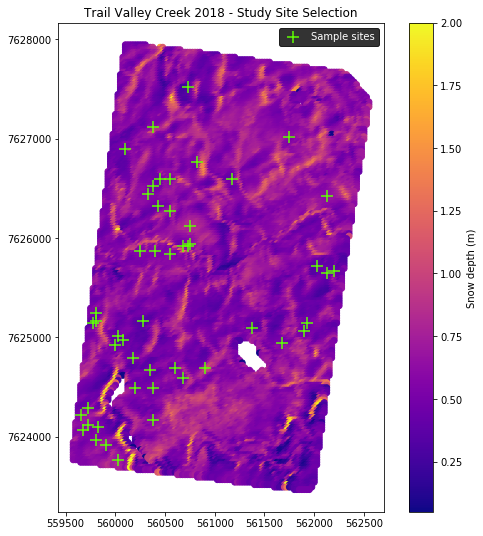

In [9]:
fig, ax = plt.subplots(figsize=(9,9))

# plot the snow depth "raster data" (actually vector points, but at default markersize it looks like a raster)
siksik_data.loc[
    siksik_data.geometry.within(siksik_geoms) # temporarily spatial-subset before plotting (doesn't alter siksik_data)
].plot(
    ax=ax, 
    column='snow_depth',
    cmap='plasma', # not a great cmap for showing snow, but just an example of the built-in colormaps
    vmin=snow_min,
    vmax=snow_max
)

# plot the selected sites
sites.plot(
    ax=ax, 
    marker='+', 
    color='#5fff02', # hex colors are a-ok too
    markersize=128, 
    label='Sample sites', 
    legend=True
)

ax.set_title('Trail Valley Creek 2018 - Study Site Selection')
# example of fancy legend
leg = ax.legend(facecolor='black', edgecolor='black')
[text.set_color('white') for text in leg.get_texts()]

# the annoying colorbar manually done using matplotlib
sm = plt.cm.ScalarMappable(
    cmap='plasma', 
    norm=plt.Normalize(vmin=snow_min, vmax=snow_max)
)
sm._A = [] # data range safe to be empty since we've manually specified vmin/vmax in both the plot and the colorbar
cbar = fig.colorbar(sm)
cbar.set_label('Snow depth (m)')

## Multi-axis plot example

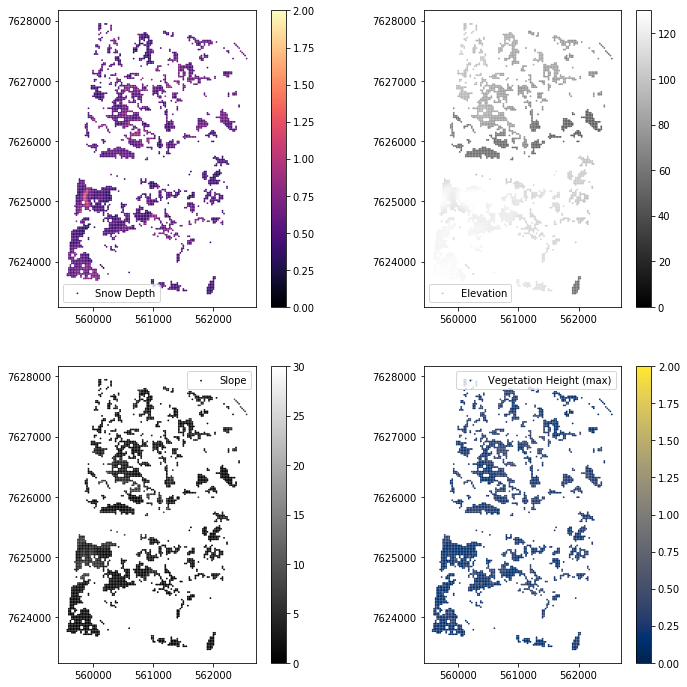

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))
snow, dem, slope, veg = axes.ravel()
siksik_sub.plot(ax=snow, column='snow_depth', markersize=0.6, vmin=0, vmax=2, cmap='magma', label='Snow Depth', legend=True)
siksik_sub.plot(ax=dem, column='dem_value', markersize=0.6, vmin=0, vmax=130, cmap='gray', label='Elevation', legend=True)
siksik_sub.plot(ax=slope, column='slope_valu', markersize=0.6, vmin=0, vmax=30, cmap='gray', label='Slope', legend=True)
siksik_sub.plot(ax=veg, column='vegheight_', markersize=0.6, vmin=0, vmax=2, cmap='cividis', label='Vegetation Height (max)', legend=True)
snow.legend()
dem.legend()
slope.legend()
veg.legend();